# ライブラリ

In [3]:
import pandas as pd
import time
from tqdm.notebook import tqdm
import pickle
import re 
from urllib.request import urlopen
import numpy as np
import requests
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations
import warnings
warnings.simplefilter(action="ignore")

import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_o

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

# 関数

In [294]:
#min_thresholdの値から1までを100等分する
def gain(return_func, X, n_samples=100, range_=[0.5, 3.5]):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = range_[1] * i / n_samples + range_[0] * (1 - (i / n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[threshold] = {"return_rate":return_rate,
                                "n_hits":n_hits,
                                "std":std,
                                "n_bets":n_bets}
    return pd.DataFrame(gain).T

# yearに値を入れればいい
def race_id_c(year):
    race_id_list = []
    
    race_id_head = year
    for place in range(1,11,1):
        for kai in range(1,6,1):
            for day in range(1,13,1):
                for r in range(1,13,1):
                    race_id = str(place).zfill(2) + str(kai).zfill(2) +\
                    str(day).zfill(2) + str(r).zfill(2)
                    race_ids = race_id_head + race_id
                    race_id_list.append(race_ids)
    return race_id_list

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

def plot(df, label=' '):
    plt.fill_between(df.index, y1=df['return_rate']-df['std'],
        y2=df['return_rate']+df['std'],alpha=0.3)
 
    plt.plot(df.index, df['return_rate'], label=label)
    plt.legend()
    plt.grid(True)

place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

In [ ]:
"""
trainをあたはめる際にdataframeの馬番順に直す必要がある

df = df.reset_index().sort_values(["index","馬番"]).set_index("index")
df.index.name = None

"""

In [130]:
def gain(return_func, X, n_samples=100, lower=60, min_threshold=0.6):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i / n_samples + min_threshold * (1 - (i / n_samples))
        n_bets, return_rate = return_func(X, threshold)
        if n_bets > lower:
            gain[n_bets] = return_rate
    return pd.Series(gain)

# 基本データ

In [ ]:
results_19 = pd.read_pickle('results_19.pickle')
results_20 = pd.read_pickle('results_20.pickle')
results_21 = pd.read_pickle('results_21.pickle')
results_all = pd.read_pickle('results_all.pickle')
results_all.drop(["cource_len","data"], axis=1, inplace=True)

horse_results = pd.read_pickle('horse_results-Copy1.pickle')
horse_results_20 = pd.read_pickle('horse_results_20.pickle')
horse_results_21 = pd.read_pickle('horse_results_21.pickle')

peds = pd.read_pickle('peds-Copy1.pickle')
peds_all = pd.read_pickle('peds_all.pickle')
n_peds_all = pd.read_pickle('n_peds_all')
n_peds_all2 = pd.read_pickle('n_peds_all2.pickle')

#r.data_cの馬番をsortしたもの　リークをなくすため
r_data_sort = pd.read_pickle("r_data_sort.pickle")

return_tables_19 = pd.read_pickle('Return_tables_19.pickle')
return_tables_20 = pd.read_pickle('Return_tables_20.pickle')
return_tables_21 = pd.read_pickle('Return_tables_21.pickle')
return_tables_all = pd.read_pickle("Return_tables_all.pickle")

# DataProcessor

In [10]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame() # raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_h = pd.DataFrame() #after merging horse_results
        self.data_pe = pd.DataFrame() #after merging peds
        self.data_c = pd.DataFrame() #after processing categorical features
        self.data_ = pd.DataFrame()
        #self.no_peds #親データがないhorse_id_list
    
    # 馬の過去成績のデータ追加    
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
        self.data_h.drop(["開催"],axis=1, inplace=True)
    
    # 馬の親データの追加                
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds,left_on='horse_id',
        right_index=True, how='left')
        
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
    
    # 質的変数への変換        
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        #ラベルエンコーディング　horse_id,jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.data_c = df
     
    
# Results class             
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    # path_listはpickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list, pre_race_results={}):
        race_results = pre_race_results
        for race_id in tqdm(race_id_list):
            if race_id in race_results.key():
                continue
            
            try:
                time.sleep(1)
                url = "https://db.netkeiba.com/race/" + race_id
                df = pd.read_html(url)[0]
                html = requests.get(url)
                html.encode = "EUC-JP"
                soup = BeautifulSoup(html.text, "html.parser")
                
                texts = (
                    soup.find("div", attrs={"class" : "data_intro"}).find_all("p")[0].tesxt
                    + soup.find("div", attrs={"class" : "data_intro"}).find_all("p")[1].tesxt
                )
                info = re.findall(r"\w+", texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
                    if text in ["良", "稍重", "稍", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)
                        
                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)
                
                race_results[race_id] = df 
                
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        return race_results
        # 一度dataframe型に直さずに出力を返す        
        #return race_results
        
    def to_data_frame(race_results):
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
        
        
        
    # to_dataframe関数で出力後にdataframe型に変換が可能            
    #def to_dataframe(race_results):
        #race_results_df = pd.concat([race_results[key] for key in race_results])
        
        #r.data_rr = race_results_df                    
                
    
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける (馬体重修正するかも)
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重"]\
            .str.split("(", expand=True)[1].replace("前計不", "0").str[:-1].astype(dtype = int)

        # データをint, floatに変換
        df["単勝"] = df["単勝"].astype(float)
        df['course_len'] = df['course_len'].astype(float) // 100

        # 不要な列を削除
        df.drop(["タイム", "着差", "調教師", "性齢", "馬体重","馬名","騎手","人気","着順"], axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
        
        df['開催'] = df.index.map(lambda x: str(x)[4:6])
        
        self.data_p = df
        
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)
  
    
# ShutubaTable class        
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
        
    @classmethod    
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T
            
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")
            
            texts = soup.find("div", attrs={"class":"RaceData01"}).text
            texts = re.findall(r"\w+", texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "稍", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)
            
            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        return cls(data)

            
    def preprocessing(self):
        df = self.data.copy()
        
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df["馬体重(増減)"] != '--']
        df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)
        
        df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1].replace("前計不)", "0)").str[:-1].astype(dtype = int)
        
        #df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1]
        #df["体重変化"] = df["体重変化"].replace("前計不)", "0)")
        #df["体重変化"] = df["体重変化"].str[:-1].astype(int)
        
        df["date"] = pd.to_datetime(df["date"])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

        # 不要な列を削除
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather','race_type',
        'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
        '体重', '体重変化']]
        
        self.data_p = df.rename(columns={'枠': '枠番'})
        

# Return

In [290]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    # path_listはpathではなく保存名で良い
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    
    @property #本来ならRetrun(return_tables).fukusho(retrun_tables)の形だが、
    #Retrun(return_tables).fukushoで扱える
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0','win_1','win_2']
        
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0','return_1','return_2']
         
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        
        return df.fillna(0).astype(int)
    
    @property #単勝に対して予測を行う
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tansho.columns = ['win','return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == "馬連"][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]]#.add_prefix("win_")
        #wins.columns = (["win_1","win_2"])#.add_prefix("win_")
        return_ = umaren[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        
        #for column in umaren.columns:
            #umaren[column] = pd.to_numeric(umaren[column], errors='coerce')
        return df

In [291]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    # path_listはpathではなく保存名で良い
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(0.7)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    
    @property #本来ならRetrun(return_tables).fukusho(retrun_tables)の形だが、
    #Retrun(return_tables).fukushoで扱える
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0','win_1','win_2']
        
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0','return_1','return_2']
         
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        
        return df.fillna(0).astype(int)
    
    @property #単勝に対して予測を行う
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tansho.columns = ['win','return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == "馬連"][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]]#.add_prefix("win_")
        #wins.columns = (["win_1","win_2"])#.add_prefix("win_")
        return_ = umaren[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        
        #for column in umaren.columns:
            #umaren[column] = pd.to_numeric(umaren[column], errors='coerce')
        return df

In [389]:
%%timeit 
for race_id in pred_list.index.unique()[:10]:
    (me.umaren.loc[race_id][0] in pred_list.loc[race_id].values) & \
    (me.umaren.loc[race_id][1] in pred_list.loc[race_id].values)

2.82 ms ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [378]:
me.umaren.loc['201909040207'][[0,1]].isin(pred_list.loc["201909040207"])

0    False
1    False
Name: 201909040207, dtype: bool

In [390]:
%%timeit 
for race_id in pred_list.index.unique()[:10]:
    me.umaren.loc[race_id][[0,1]].isin(pred_list.loc[race_id])

4.34 ms ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [381]:
set(me.umaren.loc['201909040207'][[0,1]]).issubset(set(pred_list.loc['201909040207']))

False

In [428]:
%%timeit 
for race_id in pred_list.index.unique()[:10]:
    set(me.umaren.loc[race_id][[0,1]]).issubset(set(pred_list.loc[race_id]))

5 ms ± 85.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [437]:
hit = {}
for race_id, preds in tqdm(pred_list.groupby(level=0)):
    hit[race_id] = set(me.umaren.loc[race_id][[0,1]]).issubset(set(preds))


  0%|          | 0/2356 [00:00<?, ?it/s]

# ModelEvalator

In [219]:
#第一引数にあたるxにはX_testのようなテストデータを入れる
# return_tables_path = pickle_path
class ModelEvaluator:
    def __init__(self, model, return_tables_path, std=True):
        self.model = model
        self.rt = Return.read_pickle([return_tables_path])
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
    
    #閾値(threshold)を設定する　デフォルト0.6
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    #1になる確率の予測
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X.drop(["単勝"],axis=1))[:,1], index=X.index)
        if self.std:
            standerd_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standerd_scaler)
        proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba 
    
    #auc曲線のスコアを求める
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    #各成分の特徴量の強さの表示 デフォルト20
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features":X.columns, 
                                  "importance":self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    #閾値を通して1と判定されたものだけをpred_tableとして出力する
    def pred_table(self, X, threshold=0.6, bet_only = True):
        pred_table = X.copy()[['馬番',"単勝"]]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番',"単勝"]]
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        n_hits = len(df[df["win"]==df["馬番"]])
        money += df[df['win']==df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits
    
    def tansho_return_proper(self, X, threshold=0.5):
        #モデルによって儲かると判断された馬
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        #払い戻しの際にpred_tableを混ぜる
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        #単勝適正回収率の計算
        return_rate = len(df.query("win == 馬番")) / (1 / pred_table["単勝"]).sum()
        n_hits = len(df.query("win == 馬番"))
        return n_bets, return_rate, n_hits 
    
    def umaren_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds, 2))
            hit[race_id] = set(
                self.umaren.loc[race_id][[0, 1]]
            ).issubset(set(preds))
        return_rate = self.umaren.index.map(hit).values * self.umaren['return'].sum() / \
            (n_bets * 100)
        return n_bets, return_rate
      

<AxesSubplot:>

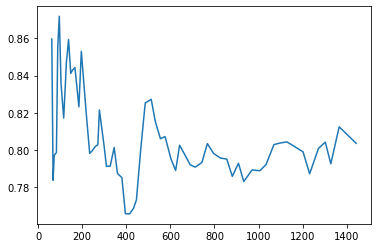

In [478]:
g.plot()

In [465]:
me.umaren

pandas.core.series.Series

# Horse_Results

In [40]:
class Horse_Results:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','着順','賞金']]
        self.preprocessing()
        #self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
    
    # path_listはHorse_Results.pickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    # 使い方
    # Horse_Results.read_pickle([pickle名])
    
    @staticmethod
    def scrape(horse_id_list):
        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                time.sleep(0.7)
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
        
    
    
    def preprocessing(self):
        df = self.horse_results.copy()
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付']) 
        df.drop(['日付'], axis=1, inplace=True)
        
        df['賞金'].fillna(0, inplace=True)
        
        self.horse_results = df
    
    #対象にした日付以降のhorse_idから平均の賞金と順位を取り出す
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query("index in @horse_id_list")
    
        #初期値はallで日付を絞らずに平均を取る
        #過去何レース分取り出すのかを指定する
        if n_samples == 'all': #terget_df内の全ての平均を取る
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0: #0より大きい数字を指定された場合指定された分のデータで平均を出す
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception ('n_sample must be > 0')

        average = filtered_df.groupby(level=0)[['着順','賞金']].mean()
        return average.rename(columns = {'着順':'着順_{}R'.format(n_samples),'賞金':'賞金_{}R'.format(n_samples)})

    #1,results(horse_id)と2,日付を入力するとresultsからdateをとる
    #dfをメインにしてdfのhorse_idをkeyにする
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merge_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merge_df
    
    #resultsにはresults_pを入れいる
    def merge_all(self, results, n_samples=[5, 9, "all"]):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

In [64]:
aass = pd.read_pickle('horse_results-Copy1.pickle')
aass.loc["2017101106"].groupby(level=0)[["R","賞金"]].mean()

,R,賞金
2017101106,5.96875,19.429412


# Peds

In [14]:
class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')
    
    # Peds.read_pickle(["pickle_path"])
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            continue
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]
                
                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis = 1, inplace = True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                
                peds_dict[horse_id] = ped.reset_index(drop = True)
                time.sleep(0.7)
                
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
                
    #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
    
        return peds_df

# gain

In [131]:
def gain(return_func, X, n_samples=100, lower=60, min_threshold=0.6):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i / n_samples + min_threshold * (1 - (i / n_samples))
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets > lower:
            gain[n_bets] = {"return_rate":return_rate,"n_hits":n_hits}
    return pd.DataFrame(gain).T

In [11]:
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

In [61]:
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

class Results:
    def __init__(self, results):
        self.results = results
        self.results_p = pd.DataFrame() #after preprocessing
        self.results_h = pd.DataFrame() #after merging horse_results
        self.results_pe = pd.DataFrame() #after merging peds
        self.results_c = pd.DataFrame() #after processing categorical features
    
    def scrape(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            self.results = self.results.append(df)
            time.sleep(1)
                
                 
    def preprocessing(self):
        df = self.results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df["単勝"] = df["単勝"].astype(float)

        # 不要な列を削除
        df.drop(["タイム", "着差", "調教師", "性齢", "馬体重"], axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")

        self.results_p = df


    # 馬の過去成績のデータ追加    
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.results_h = self.results_p.copy()
        for n_samples in n_samples_list:
            self.results_h = hr.merge_all(self.results_h, n_samples=n_samples)
            
    def merge_peds(self, peds):
        self.results_pe = self.results_h.merge(peds,left_on='horse_id',
        right_index=True, how='left')
        self.no_peds = self.results_pe[self.results_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
            
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.results_pe.copy()
        
        #ラベルエンコーディング　horse_id,jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.shutuba_tables_c = df

class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')


In [449]:
class ShutubaTable:
    def __init__(self):
        self.shutuba_tables = pd.DataFrame()
        self.shutuba_tables_p = pd.DataFrame() #after preprocessing
        self.shutuba_tables_h = pd.DataFrame() #after merging horse_results
        self.shutuba_tables_pe = pd.DataFrame() #after merging peds
        self.dshutuba_tables_c = pd.DataFrame() #after processing categorical features
    
    def scrape(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[-1])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重","稍", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            self.shutuba_tables = self.shutuba_tables.append(df)
            time.sleep(1)
                
    def preprocessing(self):
        df = self.shutuba_tables.copy()
        
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df["馬体重(増減)"] != '--']
        df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)
        
        df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1].replace("前計不)", "0)").str[:-1].astype(dtype = int)
        
        #df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1]
        #df["体重変化"] = df["体重変化"].replace("前計不)", "0)")
        #df["体重変化"] = df["体重変化"].str[:-1].astype(int)
        
        df["date"] = pd.to_datetime(df["date"])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

        # 不要な列を削除
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather','race_type',
        'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
        '体重', '体重変化']]
        
        self.shutuba_tables_p = df.rename(columns={'枠': '枠番'})
        
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.shutuba_tables_h = self.shutuba_tables_p.copy()
        for n_samples in n_samples_list:
            self.shutuba_tables_h = hr.merge_all(self.shutuba_tables_h, n_samples=n_samples)
            
    def merge_peds(self, peds):
        self.shutuba_tables_pe = self.shutuba_tables_h.merge(peds,left_on='horse_id',
        right_index=True, how='left')
        self.no_peds = self.shutuba_tables_pe[self.shutuba_tables_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
            
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.shutuba_tables_pe.copy()
        
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.shutuba_tables_c = df
        

IndentationError: unexpected indent (417021035.py, line 2)

# 訓練データ

In [18]:
r = Results(results_19)
r.preprocessing()

hr = Horse_Results(horse_results)
r.merge_horse_results(hr)


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [20]:
P = Peds(n_peds_all)
P.encode()

In [21]:
r.merge_peds(P.peds_e)
r.process_categorical()

In [22]:
r.data_c

,枠番,馬番,斤量,単勝,course_len,date,horse_id,jockey_id,rank,年齢,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201901010101,1,1,54.0,1.4,1800.0,2019-07-27,10614,152,1,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,3,3,54.0,3.5,1800.0,2019-07-27,10194,142,1,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,4,4,51.0,46.6,1800.0,2019-07-27,9851,136,1,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,8,9,51.0,56.8,1800.0,2019-07-27,11089,135,0,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,54.0,140.3,1800.0,2019-07-27,9967,47,0,2,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,57.0,15.4,1800.0,2019-10-13,1535,63,0,5,...,0,1,0,0,0,0,1,1,0,0
201908040412,2,2,57.0,36.0,1800.0,2019-10-13,189,87,0,7,...,0,1,0,0,0,0,1,1,0,0
201908040412,1,1,57.0,7.2,1800.0,2019-10-13,1985,83,0,5,...,0,1,0,0,0,0,1,1,0,0
201908040412,4,4,55.0,23.9,1800.0,2019-10-13,740,163,0,6,...,0,1,0,0,0,0,1,0,1,0


In [83]:
train, test = split_data(r.data_c)
train, valid = split_data(train)

X_train = train.drop(["rank","date"], axis=1)
y_train = train['rank']
X_test = test.drop(["rank","date"], axis=1)
y_test = test['rank']
X_valid = valid.drop(["rank","date"], axis=1)
y_valid = valid['rank']
X_train2 = train.drop(["rank","date","単勝"], axis=1)
y_train2 = train['rank']

In [146]:
me = ModelEvaluator(lgb_clf, "Return_tables-Copy1.pickle")

In [152]:
me.predict_proba(X_train2)

ValueError: Number of features of the model must match the input. Model n_features_ is 94 and input n_features is 93 

In [230]:
params = {
    "num_leaves": 4,
    "n_estimators": 80,
    "class_weight": "balanced",
    "random_state": 100,
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [43]:
me = ModelEvaluator(lgb_clf, "Return_tables-Copy1.pickle")
#me = ModelEvaluator(lgb_clf_o, return_tables)

#baseline = gain(me.tansho_return_proper, X_test)
gain(me.tansho_return_proper, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

1652    1.221519
1611    1.239783
1575    1.269691
1525    1.290000
1484    1.301044
          ...   
87      2.056289
80      2.136634
77      2.117464
71      2.159417
63      2.140475
Length: 72, dtype: float64

In [ ]:
gain(me.tansho_return_proper, X_train)

In [206]:
gain_proper = gain(me.tansho_return, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

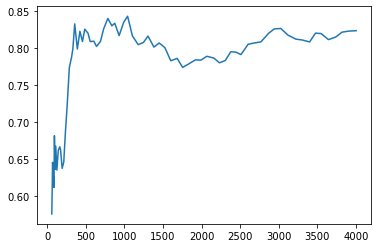

In [208]:
gain_proper.plot()

<AxesSubplot:>

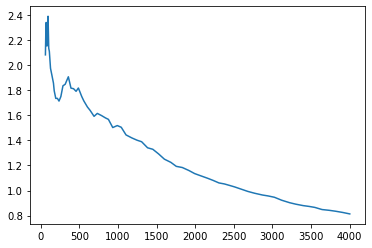

In [232]:
baseline.plot()

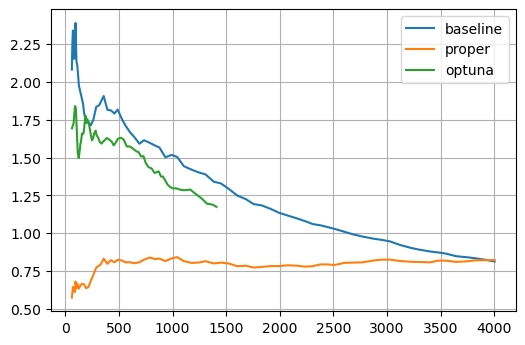

In [271]:
import matplotlib.pyplot as plt

plt.figure(dpi = 100)
baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
gain_optuna.rename("optuna").plot(legend=True)
plt.grid()


In [215]:
train, test = split_data(r.data_c)
train, valid = split_data(train)

In [15]:
import optuna.integration.lightgbm as lgb_o

In [58]:
lgb_clf

LGBMClassifier(bagging_fraction=0.9980351277335815, bagging_freq=6,
               feature_fraction=0.748, feature_pre_filter=False, lambda_l1=0.0,
               lambda_l2=0.0, num_iterations=1000, num_leaves=2,
               objective='binary', random_state=100)

In [55]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 2,
 'feature_fraction': 0.748,
 'bagging_fraction': 0.9980351277335815,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 1000}

In [31]:
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)
lgb_train2 = lgb_o.Dataset(X_train2.values, y_train2.values)

params = {
    "objective":"binary",
    "random_state": 100
}
lgb_clf_o = lgb_o.train(params, lgb_train,
                       valid_sets=(lgb_train, lgb_valid),
                       verbose_eval=100,
                       early_stopping_rounds=10)

[I 2021-10-27 14:31:11,885] A new study created in memory with name: no-name-46e0701e-c373-4084-b43b-083625971f94

feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425199:  14%|8     | 1/7 [00:00<00:02,  2.64it/s][I 2021-10-27 14:31:12,268] Trial 0 finished with value: 0.4251993806538093 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.4251993806538093.

feature_fraction, val_score: 0.425199:  14%|8     | 1/7 [00:00<00:02,  2.64it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.361608	valid_1's binary_logloss: 0.425199
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425199:  29%|#7    | 2/7 [00:00<00:01,  2.92it/s][I 2021-10-27 14:31:12,585] Trial 1 finished with value: 0.42525340600149836 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.4251993806538093.

feature_fraction, val_score: 0.425199:  29%|#7    | 2/7 [00:00<00:01,  2.92it/s]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.373256	valid_1's binary_logloss: 0.425253
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425199:  43%|##5   | 3/7 [00:01<00:01,  2.64it/s][I 2021-10-27 14:31:13,006] Trial 2 finished with value: 0.42722482487730407 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.4251993806538093.

feature_fraction, val_score: 0.425199:  43%|##5   | 3/7 [00:01<00:01,  2.64it/s]

Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.349526	valid_1's binary_logloss: 0.427225
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425199:  57%|###4  | 4/7 [00:01<00:01,  2.51it/s][I 2021-10-27 14:31:13,436] Trial 3 finished with value: 0.4262498361563317 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.4251993806538093.

feature_fraction, val_score: 0.425199:  57%|###4  | 4/7 [00:01<00:01,  2.51it/s]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.368821	valid_1's binary_logloss: 0.42625
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425060:  71%|####2 | 5/7 [00:02<00:00,  2.17it/s][I 2021-10-27 14:31:14,010] Trial 4 finished with value: 0.42505967236002384 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.42505967236002384.

feature_fraction, val_score: 0.425060:  71%|####2 | 5/7 [00:02<00:00,  2.17it/s]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.365907	valid_1's binary_logloss: 0.42506
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425060:  86%|#####1| 6/7 [00:02<00:00,  1.86it/s][I 2021-10-27 14:31:14,698] Trial 5 finished with value: 0.4282720027202206 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.42505967236002384.

feature_fraction, val_score: 0.425060:  86%|#####1| 6/7 [00:02<00:00,  1.86it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.356363	valid_1's binary_logloss: 0.428272
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



feature_fraction, val_score: 0.425060: 100%|######| 7/7 [00:03<00:00,  2.25it/s]


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.372515	valid_1's binary_logloss: 0.426515



num_leaves, val_score: 0.425060:  15%|#6         | 3/20 [03:00<17:00, 60.05s/it]
IOStream.flush timed out



[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.388174	valid_1's binary_logloss: 0.422838


num_leaves, val_score: 0.422838:   5%|5          | 1/20 [00:10<03:10, 10.01s/it][I 2021-10-27 14:31:25,022] Trial 7 finished with value: 0.4228382165363689 and parameters: {'num_leaves': 10}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:   5%|5          | 1/20 [00:10<03:10, 10.01s/it]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  10%|#1         | 2/20 [00:10<01:20,  4.46s/it][I 2021-10-27 14:31:25,594] Trial 8 finished with value: 0.43430532680664635 and parameters: {'num_leaves': 128}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  10%|#1         | 2/20 [00:10<01:20,  4.46s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.304332	valid_1's binary_logloss: 0.434305
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  15%|#6         | 3/20 [00:11<00:44,  2.62s/it][I 2021-10-27 14:31:26,029] Trial 9 finished with value: 0.43210111447207333 and parameters: {'num_leaves': 87}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  15%|#6         | 3/20 [00:11<00:44,  2.62s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.320774	valid_1's binary_logloss: 0.432101
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  20%|##2        | 4/20 [00:11<00:28,  1.75s/it][I 2021-10-27 14:31:26,450] Trial 10 finished with value: 0.4286943538376026 and parameters: {'num_leaves': 60}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  20%|##2        | 4/20 [00:11<00:28,  1.75s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.339728	valid_1's binary_logloss: 0.428694
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  25%|##7        | 5/20 [00:12<00:20,  1.38s/it][I 2021-10-27 14:31:27,167] Trial 11 finished with value: 0.43984098712164693 and parameters: {'num_leaves': 252}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  25%|##7        | 5/20 [00:12<00:20,  1.38s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.246878	valid_1's binary_logloss: 0.439841
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  30%|###3       | 6/20 [00:12<00:15,  1.11s/it][I 2021-10-27 14:31:27,765] Trial 12 finished with value: 0.43573834008440954 and parameters: {'num_leaves': 163}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  30%|###3       | 6/20 [00:12<00:15,  1.11s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.273035	valid_1's binary_logloss: 0.435738
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  35%|###8       | 7/20 [00:13<00:12,  1.05it/s][I 2021-10-27 14:31:28,386] Trial 13 finished with value: 0.4392593281652912 and parameters: {'num_leaves': 227}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  35%|###8       | 7/20 [00:13<00:12,  1.05it/s]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.2673	valid_1's binary_logloss: 0.439259
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  40%|####4      | 8/20 [00:13<00:09,  1.31it/s][I 2021-10-27 14:31:28,747] Trial 14 finished with value: 0.4316743282747718 and parameters: {'num_leaves': 66}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  40%|####4      | 8/20 [00:13<00:09,  1.31it/s]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.347603	valid_1's binary_logloss: 0.431674
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  45%|####9      | 9/20 [00:14<00:07,  1.48it/s][I 2021-10-27 14:31:29,232] Trial 15 finished with value: 0.4321125466114208 and parameters: {'num_leaves': 81}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  45%|####9      | 9/20 [00:14<00:07,  1.48it/s]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.322655	valid_1's binary_logloss: 0.432113
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  50%|#####     | 10/20 [00:14<00:06,  1.54it/s][I 2021-10-27 14:31:29,815] Trial 16 finished with value: 0.4330800797874801 and parameters: {'num_leaves': 124}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  50%|#####     | 10/20 [00:14<00:06,  1.54it/s]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.310725	valid_1's binary_logloss: 0.43308
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.422838:  55%|#####5    | 11/20 [00:15<00:04,  1.87it/s][I 2021-10-27 14:31:30,092] Trial 17 finished with value: 0.42364145164120764 and parameters: {'num_leaves': 16}. Best is trial 7 with value: 0.4228382165363689.

num_leaves, val_score: 0.422838:  55%|#####5    | 11/20 [00:15<00:04,  1.87it/s]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.386944	valid_1's binary_logloss: 0.423641
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421553:  60%|######    | 12/20 [00:15<00:03,  2.21it/s][I 2021-10-27 14:31:30,360] Trial 18 finished with value: 0.42155272443709085 and parameters: {'num_leaves': 4}. Best is trial 18 with value: 0.42155272443709085.

num_leaves, val_score: 0.421553:  60%|######    | 12/20 [00:15<00:03,  2.21it/s]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.399645	valid_1's binary_logloss: 0.421553
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421354:  65%|######5   | 13/20 [00:15<00:02,  2.49it/s][I 2021-10-27 14:31:30,642] Trial 19 finished with value: 0.42135439360426097 and parameters: {'num_leaves': 3}. Best is trial 19 with value: 0.42135439360426097.

num_leaves, val_score: 0.421354:  65%|######5   | 13/20 [00:15<00:02,  2.49it/s]

[100]	valid_0's binary_logloss: 0.399205	valid_1's binary_logloss: 0.421457
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.39965	valid_1's binary_logloss: 0.421354
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116:  70%|#######   | 14/20 [00:15<00:02,  2.63it/s][I 2021-10-27 14:31:30,972] Trial 20 finished with value: 0.4211158075136087 and parameters: {'num_leaves': 2}. Best is trial 20 with value: 0.4211158075136087.

num_leaves, val_score: 0.421116:  70%|#######   | 14/20 [00:15<00:02,  2.63it/s]

[100]	valid_0's binary_logloss: 0.402833	valid_1's binary_logloss: 0.421633
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.401322	valid_1's binary_logloss: 0.421116
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116:  75%|#######5  | 15/20 [00:16<00:01,  2.74it/s][I 2021-10-27 14:31:31,302] Trial 21 finished with value: 0.42613028207682113 and parameters: {'num_leaves': 40}. Best is trial 20 with value: 0.4211158075136087.

num_leaves, val_score: 0.421116:  75%|#######5  | 15/20 [00:16<00:01,  2.74it/s]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.359678	valid_1's binary_logloss: 0.42613
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116:  80%|########  | 16/20 [00:16<00:01,  2.83it/s][I 2021-10-27 14:31:31,628] Trial 22 finished with value: 0.42674677237372327 and parameters: {'num_leaves': 38}. Best is trial 20 with value: 0.4211158075136087.

num_leaves, val_score: 0.421116:  80%|########  | 16/20 [00:16<00:01,  2.83it/s]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.361307	valid_1's binary_logloss: 0.426747
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116:  85%|########5 | 17/20 [00:17<00:01,  2.32it/s][I 2021-10-27 14:31:32,243] Trial 23 finished with value: 0.43516441289579116 and parameters: {'num_leaves': 180}. Best is trial 20 with value: 0.4211158075136087.

num_leaves, val_score: 0.421116:  85%|########5 | 17/20 [00:17<00:01,  2.32it/s]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.275451	valid_1's binary_logloss: 0.435164
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116:  90%|######### | 18/20 [00:17<00:00,  2.28it/s][I 2021-10-27 14:31:32,695] Trial 24 finished with value: 0.4330549154643964 and parameters: {'num_leaves': 112}. Best is trial 20 with value: 0.4211158075136087.

num_leaves, val_score: 0.421116:  90%|######### | 18/20 [00:17<00:00,  2.28it/s]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.314282	valid_1's binary_logloss: 0.433055
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116:  95%|#########5| 19/20 [00:18<00:00,  2.48it/s][I 2021-10-27 14:31:33,016] Trial 25 finished with value: 0.4272926334798132 and parameters: {'num_leaves': 37}. Best is trial 20 with value: 0.4211158075136087.

num_leaves, val_score: 0.421116:  95%|#########5| 19/20 [00:18<00:00,  2.48it/s]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.365243	valid_1's binary_logloss: 0.427293
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds



num_leaves, val_score: 0.421116: 100%|##########| 20/20 [00:18<00:00,  1.08it/s]


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.283939	valid_1's binary_logloss: 0.435326


bagging, val_score: 0.421116:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402763	valid_1's binary_logloss: 0.421798


bagging, val_score: 0.421116:  10%|#4            | 1/10 [00:00<00:02,  3.39it/s]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.40192	valid_1's binary_logloss: 0.421185
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421116:  20%|##8           | 2/10 [00:00<00:02,  3.47it/s]

[100]	valid_0's binary_logloss: 0.402868	valid_1's binary_logloss: 0.421714
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.402237	valid_1's binary_logloss: 0.421487
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421116:  30%|####2         | 3/10 [00:00<00:01,  3.56it/s]

[100]	valid_0's binary_logloss: 0.402899	valid_1's binary_logloss: 0.422027
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.40206	valid_1's binary_logloss: 0.421646
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421034:  40%|#####6        | 4/10 [00:01<00:01,  3.28it/s]

[100]	valid_0's binary_logloss: 0.402834	valid_1's binary_logloss: 0.421549
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.401193	valid_1's binary_logloss: 0.421034
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402741	valid_1's binary_logloss: 0.421544


bagging, val_score: 0.421034:  50%|#######       | 5/10 [00:01<00:01,  3.08it/s]

Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.400933	valid_1's binary_logloss: 0.421144
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421034:  60%|########4     | 6/10 [00:01<00:01,  3.11it/s]

[100]	valid_0's binary_logloss: 0.402764	valid_1's binary_logloss: 0.421776
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.401575	valid_1's binary_logloss: 0.421196
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421034:  70%|#########7    | 7/10 [00:02<00:00,  3.28it/s]

[100]	valid_0's binary_logloss: 0.403025	valid_1's binary_logloss: 0.42215
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.402231	valid_1's binary_logloss: 0.421484
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421034:  80%|###########2  | 8/10 [00:02<00:00,  3.41it/s]

[100]	valid_0's binary_logloss: 0.403126	valid_1's binary_logloss: 0.422179
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.402129	valid_1's binary_logloss: 0.421611
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421034:  90%|############6 | 9/10 [00:02<00:00,  3.38it/s]

[100]	valid_0's binary_logloss: 0.40269	valid_1's binary_logloss: 0.42184
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.400969	valid_1's binary_logloss: 0.421273
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421034: 100%|#############| 10/10 [00:03<00:00,  3.30it/s]


[100]	valid_0's binary_logloss: 0.402869	valid_1's binary_logloss: 0.421935
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.400882	valid_1's binary_logloss: 0.421146


feature_fraction_stage2, val_score: 0.421034:   0%|       | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402903	valid_1's binary_logloss: 0.421605


feature_fraction_stage2, val_score: 0.421031:  17%|1| 1/6 [00:00<00:01,  3.15it/[I 2021-10-27 14:31:36,912] Trial 37 finished with value: 0.4210306008280355 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 0.4210306008280355.
feature_fraction_stage2, val_score: 0.421031:  17%|1| 1/6 [00:00<00:01,  3.15it/

Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.401784	valid_1's binary_logloss: 0.421031
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.421031:  33%|3| 2/6 [00:00<00:01,  3.14it/[I 2021-10-27 14:31:37,232] Trial 38 finished with value: 0.42112401918227355 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 0.4210306008280355.
feature_fraction_stage2, val_score: 0.421031:  33%|3| 2/6 [00:00<00:01,  3.14it/

[100]	valid_0's binary_logloss: 0.402906	valid_1's binary_logloss: 0.421639
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.401725	valid_1's binary_logloss: 0.421124
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420905:  50%|5| 3/6 [00:00<00:00,  3.17it/[I 2021-10-27 14:31:37,544] Trial 39 finished with value: 0.4209051788548438 and parameters: {'feature_fraction': 0.748}. Best is trial 39 with value: 0.4209051788548438.
feature_fraction_stage2, val_score: 0.420905:  50%|5| 3/6 [00:00<00:00,  3.17it/

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420905:  67%|6| 4/6 [00:01<00:00,  3.19it/[I 2021-10-27 14:31:37,853] Trial 40 finished with value: 0.42113155081298825 and parameters: {'feature_fraction': 0.716}. Best is trial 39 with value: 0.4209051788548438.
feature_fraction_stage2, val_score: 0.420905:  67%|6| 4/6 [00:01<00:00,  3.19it/

[100]	valid_0's binary_logloss: 0.402834	valid_1's binary_logloss: 0.421549
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401726	valid_1's binary_logloss: 0.421132
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420905:  83%|8| 5/6 [00:01<00:00,  3.27it/[I 2021-10-27 14:31:38,147] Trial 41 finished with value: 0.4209372570781769 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 39 with value: 0.4209051788548438.
feature_fraction_stage2, val_score: 0.420905:  83%|8| 5/6 [00:01<00:00,  3.27it/

[100]	valid_0's binary_logloss: 0.402585	valid_1's binary_logloss: 0.42118
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.402079	valid_1's binary_logloss: 0.420937
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420905: 100%|#| 6/6 [00:01<00:00,  3.12it/[I 2021-10-27 14:31:38,497] Trial 42 finished with value: 0.4210640736209 and parameters: {'feature_fraction': 0.62}. Best is trial 39 with value: 0.4209051788548438.
feature_fraction_stage2, val_score: 0.420905: 100%|#| 6/6 [00:01<00:00,  3.15it/


[100]	valid_0's binary_logloss: 0.403292	valid_1's binary_logloss: 0.421974
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.401249	valid_1's binary_logloss: 0.421064


regularization_factors, val_score: 0.420905:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402709	valid_1's binary_logloss: 0.42128


regularization_factors, val_score: 0.420905:   5%| | 1/20 [00:00<00:05,  3.23it/[I 2021-10-27 14:31:38,810] Trial 43 finished with value: 0.4211084046191887 and parameters: {'lambda_l1': 2.0759636578225655, 'lambda_l2': 1.8472955697249507}. Best is trial 43 with value: 0.4211084046191887.
regularization_factors, val_score: 0.420905:   5%| | 1/20 [00:00<00:05,  3.23it/

Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.401941	valid_1's binary_logloss: 0.421108
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421164


regularization_factors, val_score: 0.420905:  10%|1| 2/20 [00:00<00:05,  3.31it/[I 2021-10-27 14:31:39,106] Trial 44 finished with value: 0.420908647344163 and parameters: {'lambda_l1': 3.247017514745793e-05, 'lambda_l2': 0.001691195219649693}. Best is trial 44 with value: 0.420908647344163.
regularization_factors, val_score: 0.420905:  10%|1| 2/20 [00:00<00:05,  3.31it/

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40187	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  15%|1| 3/20 [00:00<00:05,  3.09it/[I 2021-10-27 14:31:39,456] Trial 45 finished with value: 0.420908954201709 and parameters: {'lambda_l1': 1.3554259150021517e-08, 'lambda_l2': 0.017389976386396732}. Best is trial 44 with value: 0.420908647344163.
regularization_factors, val_score: 0.420905:  15%|1| 3/20 [00:00<00:05,  3.09it/

[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421165
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40187	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  20%|2| 4/20 [00:01<00:05,  3.03it/[I 2021-10-27 14:31:39,797] Trial 46 finished with value: 0.42090882510115846 and parameters: {'lambda_l1': 0.0032705627600200884, 'lambda_l2': 0.0054774534528650625}. Best is trial 44 with value: 0.420908647344163.
regularization_factors, val_score: 0.420905:  20%|2| 4/20 [00:01<00:05,  3.03it/

[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421165
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40187	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  25%|2| 5/20 [00:01<00:04,  3.09it/[I 2021-10-27 14:31:40,108] Trial 47 finished with value: 0.4209086425916035 and parameters: {'lambda_l1': 6.694189505369919e-07, 'lambda_l2': 0.0014999254846577088}. Best is trial 47 with value: 0.4209086425916035.
regularization_factors, val_score: 0.420905:  25%|2| 5/20 [00:01<00:04,  3.09it/

[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421164
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.401869	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  30%|3| 6/20 [00:01<00:04,  3.13it/[I 2021-10-27 14:31:40,420] Trial 48 finished with value: 0.4209087157710486 and parameters: {'lambda_l1': 0.00010272224054801713, 'lambda_l2': 0.005064087577638078}. Best is trial 47 with value: 0.4209086425916035.
regularization_factors, val_score: 0.420905:  30%|3| 6/20 [00:01<00:04,  3.13it/

[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421164
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40187	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  35%|3| 7/20 [00:02<00:04,  3.18it/[I 2021-10-27 14:31:40,724] Trial 49 finished with value: 0.4209091936037069 and parameters: {'lambda_l1': 0.0176667573571458, 'lambda_l2': 0.0007966599409082964}. Best is trial 47 with value: 0.4209086425916035.
regularization_factors, val_score: 0.420905:  35%|3| 7/20 [00:02<00:04,  3.18it/

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421165
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40187	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  40%|4| 8/20 [00:02<00:04,  2.87it/[I 2021-10-27 14:31:41,144] Trial 50 finished with value: 0.4209626380804921 and parameters: {'lambda_l1': 5.09756591689669e-08, 'lambda_l2': 0.7844045849707512}. Best is trial 47 with value: 0.4209086425916035.
regularization_factors, val_score: 0.420905:  40%|4| 8/20 [00:02<00:04,  2.87it/

[100]	valid_0's binary_logloss: 0.402607	valid_1's binary_logloss: 0.421181
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.402033	valid_1's binary_logloss: 0.420963
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  45%|4| 9/20 [00:02<00:03,  2.94it/[I 2021-10-27 14:31:41,468] Trial 51 finished with value: 0.42090865265546995 and parameters: {'lambda_l1': 3.079137118980622e-07, 'lambda_l2': 0.0020141998162189305}. Best is trial 47 with value: 0.4209086425916035.
regularization_factors, val_score: 0.420905:  45%|4| 9/20 [00:02<00:03,  2.94it/

[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421164
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.40187	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402718	valid_1's binary_logloss: 0.421355


regularization_factors, val_score: 0.420905:  50%|5| 10/20 [00:03<00:03,  2.80it[I 2021-10-27 14:31:41,864] Trial 52 finished with value: 0.42100189587344844 and parameters: {'lambda_l1': 0.0020881219695775208, 'lambda_l2': 7.710350580557382}. Best is trial 47 with value: 0.4209086425916035.
regularization_factors, val_score: 0.420905:  50%|5| 10/20 [00:03<00:03,  2.80it

Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.401728	valid_1's binary_logloss: 0.421002
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  55%|5| 11/20 [00:03<00:03,  2.88it[I 2021-10-27 14:31:42,190] Trial 53 finished with value: 0.4209051789858472 and parameters: {'lambda_l1': 2.87295408467766e-06, 'lambda_l2': 2.2527216122186036e-06}. Best is trial 53 with value: 0.4209051789858472.
regularization_factors, val_score: 0.420905:  55%|5| 11/20 [00:03<00:03,  2.88it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  60%|6| 12/20 [00:04<00:03,  2.60it[I 2021-10-27 14:31:42,660] Trial 54 finished with value: 0.42090517896796686 and parameters: {'lambda_l1': 2.603817394964935e-06, 'lambda_l2': 1.748305684883842e-06}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  60%|6| 12/20 [00:04<00:03,  2.60it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  65%|6| 13/20 [00:04<00:02,  2.46it[I 2021-10-27 14:31:43,114] Trial 55 finished with value: 0.42090517900305857 and parameters: {'lambda_l1': 4.6507729773280255e-06, 'lambda_l2': 5.043668681231716e-07}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  65%|6| 13/20 [00:04<00:02,  2.46it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  70%|7| 14/20 [00:05<00:02,  2.35it[I 2021-10-27 14:31:43,586] Trial 56 finished with value: 0.4209051790759283 and parameters: {'lambda_l1': 6.447381692864445e-06, 'lambda_l2': 1.3276379913508293e-06}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  70%|7| 14/20 [00:05<00:02,  2.35it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  75%|7| 15/20 [00:05<00:02,  2.28it[I 2021-10-27 14:31:44,056] Trial 57 finished with value: 0.4209051791513139 and parameters: {'lambda_l1': 9.450463254342915e-07, 'lambda_l2': 1.3841910561694858e-05}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  75%|7| 15/20 [00:05<00:02,  2.28it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  80%|8| 16/20 [00:05<00:01,  2.27it[I 2021-10-27 14:31:44,499] Trial 58 finished with value: 0.4209086220422916 and parameters: {'lambda_l1': 0.00027944684456150356, 'lambda_l2': 1.1574187633813302e-08}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  80%|8| 16/20 [00:05<00:01,  2.27it

[100]	valid_0's binary_logloss: 0.402591	valid_1's binary_logloss: 0.421164
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.401869	valid_1's binary_logloss: 0.420909
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  85%|8| 17/20 [00:06<00:01,  2.29it[I 2021-10-27 14:31:44,930] Trial 59 finished with value: 0.4209784020095698 and parameters: {'lambda_l1': 0.37466695858488697, 'lambda_l2': 2.8138804988942682e-05}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  85%|8| 17/20 [00:06<00:01,  2.29it

[100]	valid_0's binary_logloss: 0.402608	valid_1's binary_logloss: 0.421207
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.402036	valid_1's binary_logloss: 0.420978
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  90%|9| 18/20 [00:06<00:00,  2.18it[I 2021-10-27 14:31:45,438] Trial 60 finished with value: 0.4209051793000916 and parameters: {'lambda_l1': 1.5140414797247163e-05, 'lambda_l2': 3.9097435740903966e-08}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  90%|9| 18/20 [00:06<00:00,  2.18it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905:  95%|9| 19/20 [00:07<00:00,  2.08it[I 2021-10-27 14:31:45,968] Trial 61 finished with value: 0.4209051796465118 and parameters: {'lambda_l1': 1.2861072879311216e-07, 'lambda_l2': 4.170067304816493e-05}. Best is trial 54 with value: 0.42090517896796686.
regularization_factors, val_score: 0.420905:  95%|9| 19/20 [00:07<00:00,  2.08it

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420905: 100%|#| 20/20 [00:07<00:00,  2.02it[I 2021-10-27 14:31:46,500] Trial 62 finished with value: 0.42090517891083634 and parameters: {'lambda_l1': 1.3884489344070321e-06, 'lambda_l2': 5.876596386995932e-07}. Best is trial 62 with value: 0.42090517891083634.
regularization_factors, val_score: 0.420905: 100%|#| 20/20 [00:08<00:00,  2.50it


[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905


min_data_in_leaf, val_score: 0.420905:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420905:  20%|#2    | 1/5 [00:00<00:01,  2.35it/s]

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420905:  40%|##4   | 2/5 [00:00<00:01,  2.53it/s]

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195


min_data_in_leaf, val_score: 0.420905:  60%|###6  | 3/5 [00:01<00:00,  2.67it/s]

Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420905:  80%|####8 | 4/5 [00:01<00:00,  2.54it/s]

[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13440
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.402592	valid_1's binary_logloss: 0.421195


min_data_in_leaf, val_score: 0.420905: 100%|######| 5/5 [00:01<00:00,  2.52it/s]

Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.420905


In [63]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 2,
 'feature_fraction': 0.748,
 'bagging_fraction': 0.9980351277335815,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 1000}

In [64]:
lgb_train2 = lgb_o.Dataset(X_train2.values, y_train2.values)

params = {
    "objective":"binary",
    "random_state": 100
}
lgb_clf_o2 = lgb_o.train2(params, lgb_train2,
                       valid_sets=(lgb_train2, lgb_valid),
                       verbose_eval=100,
                       early_stopping_rounds=10)

AttributeError: module 'optuna.integration.lightgbm' has no attribute 'train2'

In [33]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 2,
 'feature_fraction': 0.748,
 'bagging_fraction': 0.9980351277335815,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [29]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.3791597033646388e-08,
 'lambda_l2': 1.347298109719846e-08,
 'num_leaves': 256,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8083827851133965,
 'bagging_freq': 3,
 'min_child_samples': 5,
 'num_iterations': 1000,
 'early_stopping_round': 10
}

In [34]:
lgb_clf_o.params.pop("early_stopping_round")

10

In [262]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.3791597033646388e-08,
 'lambda_l2': 1.347298109719846e-08,
 'num_leaves': 256,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8083827851133965,
 'bagging_freq': 3,
 'min_child_samples': 5}

In [227]:
# ハイパーオアメータを使ってlgb_trainを学習
# 学習したもお出るを使って分割したlgb_validで検証
# 検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習
# 上記を繰り返す　
feature_pre_filter チューニング時はfalse
lambda_l1,2 正則化、過学習防止
num_leaves　葉の数
feature_fraction x 特徴量のx％で１つの木を育てる
bagging_fraction x データをx分だけ使って木を育てる　
bagging_freq　バギングする頻度
min_child_samples　最終的に一つの葉に残るデータ数

In [35]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

/Users/ko/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.9980351277335815, bagging_freq=6,
               feature_fraction=0.748, feature_pre_filter=False, lambda_l1=0.0,
               lambda_l2=0.0, num_iterations=1000, num_leaves=2,
               objective='binary', random_state=100)

In [540]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train2.values, y_train2.values)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8083827851133965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083827851133965
[LightGBM] [Warning] lambda_l2 is set=1.347298109719846e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.347298109719846e-08
[LightGBM] [Warning] lambda_l1 is set=1.3791597033646388e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3791597033646388e-08


LGBMClassifier(bagging_fraction=0.8083827851133965, bagging_freq=3,
               feature_fraction=1.0, feature_pre_filter=False,
               lambda_l1=1.3791597033646388e-08,
               lambda_l2=1.347298109719846e-08, min_child_samples=5,
               num_leaves=256, objective='binary', random_state=100)

In [502]:
X_test

,枠番,馬番,斤量,単勝,course_len,horse_id,jockey_id,年齢,体重,体重変化,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201909040104,4,5,54.0,1.4,1400.0,10663,60,2,436,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,6,10,54.0,15.3,1400.0,8494,14,2,470,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,7,11,51.0,96.7,1400.0,8347,136,2,418,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,4,6,54.0,7.2,1400.0,11065,25,2,494,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,2,2,54.0,170.4,1400.0,9465,38,2,420,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201909050902,5,10,54.0,66.7,1400.0,10254,110,2,474,-10,...,0,1,0,0,0,1,0,0,1,0
201909050902,3,5,54.0,470.9,1400.0,8485,172,2,406,-2,...,0,1,0,0,0,1,0,0,1,0
201909050902,6,12,55.0,265.3,1400.0,8919,85,2,502,8,...,0,1,0,0,0,1,0,1,0,0
201909050902,4,8,54.0,24.2,1400.0,10352,70,2,438,0,...,0,1,0,0,0,1,0,0,1,0


In [513]:
X_test2 = X_test.drop('単勝', axis=1)

In [509]:
X_test

,枠番,馬番,斤量,単勝,course_len,horse_id,jockey_id,年齢,体重,体重変化,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201909040104,4,5,54.0,1.4,1400.0,10663,60,2,436,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,6,10,54.0,15.3,1400.0,8494,14,2,470,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,7,11,51.0,96.7,1400.0,8347,136,2,418,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,4,6,54.0,7.2,1400.0,11065,25,2,494,0,...,1,0,0,1,0,0,0,0,1,0
201909040104,2,2,54.0,170.4,1400.0,9465,38,2,420,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201909050902,5,10,54.0,66.7,1400.0,10254,110,2,474,-10,...,0,1,0,0,0,1,0,0,1,0
201909050902,3,5,54.0,470.9,1400.0,8485,172,2,406,-2,...,0,1,0,0,0,1,0,0,1,0
201909050902,6,12,55.0,265.3,1400.0,8919,85,2,502,8,...,0,1,0,0,0,1,0,1,0,0
201909050902,4,8,54.0,24.2,1400.0,10352,70,2,438,0,...,0,1,0,0,0,1,0,0,1,0


In [514]:
X_test2

,枠番,馬番,斤量,course_len,horse_id,jockey_id,年齢,体重,体重変化,着順_5R,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201909040104,4,5,54.0,1400.0,10663,60,2,436,0,NaN,...,1,0,0,1,0,0,0,0,1,0
201909040104,6,10,54.0,1400.0,8494,14,2,470,0,NaN,...,1,0,0,1,0,0,0,0,1,0
201909040104,7,11,51.0,1400.0,8347,136,2,418,0,NaN,...,1,0,0,1,0,0,0,0,1,0
201909040104,4,6,54.0,1400.0,11065,25,2,494,0,NaN,...,1,0,0,1,0,0,0,0,1,0
201909040104,2,2,54.0,1400.0,9465,38,2,420,0,NaN,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201909050902,5,10,54.0,1400.0,10254,110,2,474,-10,10.00,...,0,1,0,0,0,1,0,0,1,0
201909050902,3,5,54.0,1400.0,8485,172,2,406,-2,8.00,...,0,1,0,0,0,1,0,0,1,0
201909050902,6,12,55.0,1400.0,8919,85,2,502,8,10.00,...,0,1,0,0,0,1,0,1,0,0
201909050902,4,8,54.0,1400.0,10352,70,2,438,0,5.75,...,0,1,0,0,0,1,0,0,1,0


<AxesSubplot:>

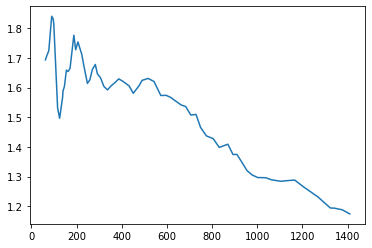

In [285]:
gain_optuna.plot()

In [549]:
me.feature_importance(X_test)

,features,importance
3,単勝,1288
6,jockey_id,825
11,賞金_5R,752
10,着順_5R,705
13,賞金_9R,668
12,着順_9R,663
9,体重変化,658
8,体重,650
1,馬番,600
15,賞金_allR,598


# horse_resultsに着差、通過の特徴量を追加

In [25]:
horse_results["着差"].map(lambda x:0 if x<0 else x)

2017105318    0.9
2017105318    1.9
2017105318    0.2
2017105318    0.6
2017105318    0.0
             ... 
2017101106    1.6
2017101106    1.7
2017101106    1.8
2017101106    1.6
2017101106    1.6
Name: 着差, Length: 251337, dtype: float64

In [385]:
class Horse_Results:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','着順','賞金','着差','通過']]
        self.preprocessing()
        #self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
    
    # path_listはHorse_Results.pickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    # 使い方
    # Horse_Results.read_pickle([pickle名])
    
    @staticmethod
    def scrape(horse_id_list):
        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
        
    
    
    def preprocessing(self):
        df = self.horse_results.copy()
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付']) 
        df.drop(['日付'], axis=1, inplace=True)
        
        df['賞金'].fillna(0, inplace=True)
        
        df['着差'] = df['着差'].map(lambda x:0 if x<0 else x)
                                
        def corner(x, n):
            if type(x) != str:
                return x
            elif n == 4:
                return int(re.findall(r"\d+", x)[-1])
            elif n == 1:
                return int(re.findall(r"\d+", x)[0])
            
        df['final_corner'] = df['通過'].map(lambda x: corner(x, n=4))
        df['first_corner'] = df['通過'].map(lambda x: corner(x, n=1))
        
        df['final_rank'] = df['final_corner'] - df['着順']
        df['first_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_rank'] - df['final_rank']

        self.horse_results = df
    
    #対象にした日付以降のhorse_idから平均の賞金と順位を取り出す
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query("index in @horse_id_list")
    
        #初期値はallで日付を絞らずに平均を取る
        #過去何レース分取り出すのかを指定する
        if n_samples == 'all': #terget_df内の全ての平均を取る
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0: #0より大きい数字を指定された場合指定された分のデータで平均を出す
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception ('n_sample must be > 0')

        average = filtered_df.groupby(level=0)[['着順','賞金','着差','first_corner','first_rank','first_to_final']].mean()
        return average.rename(columns = {
            '着順':'着順_{}R'.format(n_samples),
            '賞金':'賞金_{}R'.format(n_samples),
            '着差':'着差_{}R'.format(n_samples),
            'first_corner':'first_corner_{}R'.format(n_samples),
            'first_rank':'first_rank_{}R'.format(n_samples),
            'first_to_final':'first_to_final_{}R'.format(n_samples)})

    #1,results(horse_id)と2,日付を入力するとresultsからdateをとる
    #dfをメインにしてdfのhorse_idをkeyにする
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merge_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merge_df
    
    #resultsにはresults_pを入れいる
    def merge_all(self, results, n_samples=[5, 9, "all"]):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

In [358]:
#第一引数にあたるxにはX_testのようなテストデータを入れる
# return_tables_path = pickle_path
class ModelEvaluator:
    def __init__(self, model, return_tables_list, std=True):
        self.model = model
        self.rt = Return.read_pickle(return_tables_list)
        #self.rt = return_tables_list
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
    
    #閾値(threshold)を設定する　デフォルト0.6
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    #1になる確率の予測
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X.drop(["単勝"],axis=1))[:,1], index=X.index)
        if self.std:
            standerd_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standerd_scaler)
        proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba 
    
    #auc曲線のスコアを求める
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    #各成分の特徴量の強さの表示 デフォルト20
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features":X.columns, 
                                  "importance":self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    #閾値を通して1と判定されたものだけをpred_tableとして出力する
    def pred_table(self, X, threshold=0.6, bet_only = True):
        pred_table = X.copy()[['馬番',"単勝"]]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番',"単勝"]]
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        n_hits = len(df[df["win"]==df["馬番"]])
        money += df[df['win']==df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        
        std = ((df['win'] == df['馬番'])*\
               df['return']).groupby(level=0).sum().std() *\
                np.sqrt(n_races)/(n_bets*100)
        
        
        return n_bets, return_rate, n_hits, std
        #self.df = df
        #self.tansho_df = self.tansho.copy()
    
    def tansho_return_proper(self, X, threshold=0.5):
        #モデルによって儲かると判断された馬
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        #払い戻しの際にpred_tableを混ぜる
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        #self.s_df = df 
        
        bet_money = (1 / pred_table["単勝"]).sum()
    
        std = ((df["win"] == df["馬番"]).astype(int).groupby(level=0).sum().std()\
               * np.sqrt(n_races) / bet_money)
        
        #単勝適正回収率の計算
        n_hits = len(df.query("win == 馬番"))
        return_rate = n_hits / (1/ pred_table['単勝']).sum()
        
        return n_bets, return_rate, n_hits, std
    
    def umaren_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds, 2))
            hit[race_id] = set(
                self.umaren.loc[race_id][[0, 1]]
            ).issubset(set(preds))
        return_rate = self.umaren.index.map(hit).values * self.umaren['return'].sum() / \
            (n_bets * 100)
        return n_bets, return_rate
      

In [386]:
hr = Horse_Results.read_pickle(["horse_results-Copy1.pickle"])
#hr.horse_results
hr.horse_results#.loc['2017101106']

,着順,賞金,着差,通過,date,final_corner,first_corner,final_rank,first_rank,first_to_final
2017105318,11,0.0,0.9,3-3-3-2,2021-07-17,2.0,3.0,-9.0,-8.0,1.0
2017105318,16,0.0,1.9,1-1-1-1,2020-12-26,1.0,1.0,-15.0,-15.0,0.0
2017105318,4,110.0,0.2,7-6-4-4,2020-08-02,4.0,7.0,0.0,3.0,3.0
2017105318,6,0.0,0.6,10-7-7-2,2019-08-31,2.0,10.0,-4.0,4.0,8.0
2017105318,1,500.0,0.0,1-1-1-1,2019-07-27,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2017101106,7,0.0,1.6,5-5-6-7,2020-03-14,7.0,5.0,0.0,-2.0,-2.0
2017101106,9,0.0,1.7,8-8-10-9,2020-02-29,9.0,8.0,0.0,-1.0,-1.0
2017101106,13,0.0,1.8,1-1-1-1,2020-02-09,1.0,1.0,-12.0,-12.0,0.0
2017101106,5,51.0,1.6,10-9-9-7,2020-01-25,7.0,10.0,2.0,5.0,3.0


In [387]:
r = Results.read_pickle(["results_19.pickle"])
r.preprocessing()
r.merge_horse_results(hr)

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [388]:
p = Peds(n_peds_all)
p.encode()

In [389]:
r.merge_peds(p.peds_e)

In [390]:
r.process_categorical()

In [363]:
rr = r.data_c.drop(['単勝'],axis=1)
#r.data_c['単勝']

In [20]:
#ハイパーパラメーターをoptunaで求める際のsplit_data
train, test = split_data(r.data_c)
train, valid = split_data(train)

#学習データ
X_train = train.drop(["rank","date"], axis=1)
y_train = train['rank']

#テストデータ
X_test = test.drop(["rank","date"], axis=1)
y_test = test['rank']

#検証データ
X_valid = valid.drop(["rank","date"], axis=1)
y_valid = valid["rank"]

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    "objective":"binary",
    "random_state": 100
}
lgb_clf_o = lgb_o.train(params, lgb_train,
                valid_sets=(lgb_train, lgb_valid),
                verbose_eval=100,
                early_stopping_rounds=10)

[I 2021-11-11 11:40:32,146] A new study created in memory with name: no-name-430f8b5f-b93b-4f33-9cf8-d625dbcf5175
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.426658:  14%|8     | 1/7 [00:00<00:02,  2.51it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.362188	valid_1's binary_logloss: 0.426658
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.426658:  29%|#7    | 2/7 [00:00<00:01,  2.75it/s]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.375184	valid_1's binary_logloss: 0.42718
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.425020:  43%|##5   | 3/7 [00:01<00:01,  2.79it/s]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.371855	valid_1's binary_logloss: 0.42502
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.424703:  57%|###4  | 4/7 [00:01<00:01,  2.79it/s]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.373605	valid_1's binary_logloss: 0.424703
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.424703:  71%|####2 | 5/7 [00:02<00:01,  1.93it/s]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.346943	valid_1's binary_logloss: 0.427824
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.423883:  86%|#####1| 6/7 [00:02<00:00,  1.84it/s]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.370592	valid_1's binary_logloss: 0.423883
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.423883: 100%|######| 7/7 [00:03<00:00,  2.00it/s]


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.361801	valid_1's binary_logloss: 0.424848


num_leaves, val_score: 0.423883:   0%|                   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:   5%|5          | 1/20 [00:00<00:18,  1.02it/s]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.258402	valid_1's binary_logloss: 0.436158
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:  10%|#1         | 2/20 [00:01<00:12,  1.47it/s]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.352579	valid_1's binary_logloss: 0.426714
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:  15%|#6         | 3/20 [00:02<00:11,  1.46it/s]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.278942	valid_1's binary_logloss: 0.434498
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:  20%|##2        | 4/20 [00:02<00:10,  1.60it/s]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.327761	valid_1's binary_logloss: 0.430827
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:  25%|##7        | 5/20 [00:03<00:10,  1.47it/s]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.261723	valid_1's binary_logloss: 0.439078
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:  30%|###3       | 6/20 [00:03<00:08,  1.69it/s]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.352579	valid_1's binary_logloss: 0.426714
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.423883:  35%|###8       | 7/20 [00:04<00:08,  1.50it/s]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.273372	valid_1's binary_logloss: 0.435846
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.422098:  40%|####4      | 8/20 [00:05<00:06,  1.81it/s]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.393537	valid_1's binary_logloss: 0.422098
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.422098:  45%|####9      | 9/20 [00:05<00:06,  1.78it/s]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.304346	valid_1's binary_logloss: 0.432636
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.422098:  50%|#####     | 10/20 [00:06<00:06,  1.65it/s]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.277104	valid_1's binary_logloss: 0.43435
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.422098:  55%|#####5    | 11/20 [00:06<00:04,  1.93it/s]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.393537	valid_1's binary_logloss: 0.422098
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  60%|######    | 12/20 [00:06<00:03,  2.26it/s]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.401535	valid_1's binary_logloss: 0.421059
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  65%|######5   | 13/20 [00:07<00:02,  2.48it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.397067	valid_1's binary_logloss: 0.42128
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  70%|#######   | 14/20 [00:07<00:02,  2.35it/s]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.335633	valid_1's binary_logloss: 0.428356
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  75%|#######5  | 15/20 [00:08<00:02,  2.05it/s]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.296199	valid_1's binary_logloss: 0.433558
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  80%|########  | 16/20 [00:08<00:01,  2.00it/s]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.317442	valid_1's binary_logloss: 0.429648
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  85%|########5 | 17/20 [00:09<00:01,  2.28it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.397067	valid_1's binary_logloss: 0.42128
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  90%|######### | 18/20 [00:09<00:00,  2.24it/s]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.354792	valid_1's binary_logloss: 0.426111
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059:  95%|#########5| 19/20 [00:10<00:00,  2.01it/s]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.301751	valid_1's binary_logloss: 0.435194
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.421059: 100%|##########| 20/20 [00:10<00:00,  1.89it/s]


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.370592	valid_1's binary_logloss: 0.423883


bagging, val_score: 0.421059:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421059:  10%|#4            | 1/10 [00:00<00:02,  4.01it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.402416	valid_1's binary_logloss: 0.421636
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.39931	valid_1's binary_logloss: 0.421248


bagging, val_score: 0.421059:  20%|##8           | 2/10 [00:00<00:02,  3.65it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.39974	valid_1's binary_logloss: 0.421118


bagging, val_score: 0.421059:  30%|####2         | 3/10 [00:00<00:01,  3.59it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421059:  40%|#####6        | 4/10 [00:01<00:01,  3.06it/s]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.397534	valid_1's binary_logloss: 0.421096
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.421059:  50%|#######       | 5/10 [00:01<00:01,  3.17it/s]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.400022	valid_1's binary_logloss: 0.421877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.420978:  60%|########4     | 6/10 [00:01<00:01,  3.27it/s]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.40093	valid_1's binary_logloss: 0.420978
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.420978:  70%|#########7    | 7/10 [00:02<00:00,  3.41it/s]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.402153	valid_1's binary_logloss: 0.421446
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.420978:  80%|###########2  | 8/10 [00:02<00:00,  3.61it/s]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.402286	valid_1's binary_logloss: 0.421741
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.420978:  90%|############6 | 9/10 [00:02<00:00,  3.66it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401635	valid_1's binary_logloss: 0.421441
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.420978: 100%|#############| 10/10 [00:02<00:00,  3.52it/s]


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.401056	valid_1's binary_logloss: 0.421259


feature_fraction_stage2, val_score: 0.420978:   0%|       | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420978:  17%|1| 1/6 [00:00<00:01,  3.24it/[I 2021-11-11 11:40:49,356] Trial 37 finished with value: 0.42097753767397406 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.42097753767397406.
feature_fraction_stage2, val_score: 0.420978:  17%|1| 1/6 [00:00<00:01,  3.24it/

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.40093	valid_1's binary_logloss: 0.420978
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420978:  33%|3| 2/6 [00:00<00:01,  3.46it/[I 2021-11-11 11:40:49,631] Trial 38 finished with value: 0.42122090980945287 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.42097753767397406.
feature_fraction_stage2, val_score: 0.420978:  33%|3| 2/6 [00:00<00:01,  3.46it/

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.401172	valid_1's binary_logloss: 0.421221
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420972:  50%|5| 3/6 [00:00<00:00,  3.47it/[I 2021-11-11 11:40:49,917] Trial 39 finished with value: 0.42097180412430935 and parameters: {'feature_fraction': 0.948}. Best is trial 39 with value: 0.42097180412430935.
feature_fraction_stage2, val_score: 0.420972:  50%|5| 3/6 [00:00<00:00,  3.47it/

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.40131	valid_1's binary_logloss: 0.420972
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420972:  67%|6| 4/6 [00:01<00:00,  3.54it/[I 2021-11-11 11:40:50,191] Trial 40 finished with value: 0.42097753767397406 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 39 with value: 0.42097180412430935.
feature_fraction_stage2, val_score: 0.420972:  67%|6| 4/6 [00:01<00:00,  3.54it/

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.40093	valid_1's binary_logloss: 0.420978
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420877:  83%|8| 5/6 [00:01<00:00,  3.58it/[I 2021-11-11 11:40:50,465] Trial 41 finished with value: 0.4208772375503288 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 41 with value: 0.4208772375503288.
feature_fraction_stage2, val_score: 0.420877:  83%|8| 5/6 [00:01<00:00,  3.58it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.420877: 100%|#| 6/6 [00:01<00:00,  3.59it/[I 2021-11-11 11:40:50,744] Trial 42 finished with value: 0.4211285440566922 and parameters: {'feature_fraction': 0.852}. Best is trial 41 with value: 0.4208772375503288.
feature_fraction_stage2, val_score: 0.420877: 100%|#| 6/6 [00:01<00:00,  3.53it/


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.400984	valid_1's binary_logloss: 0.421129


regularization_factors, val_score: 0.420877:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:   5%| | 1/20 [00:00<00:05,  3.48it/[I 2021-11-11 11:40:51,035] Trial 43 finished with value: 0.4213506423082304 and parameters: {'lambda_l1': 0.0003098182999648275, 'lambda_l2': 6.154452107715563}. Best is trial 43 with value: 0.4213506423082304.
regularization_factors, val_score: 0.420877:   5%| | 1/20 [00:00<00:05,  3.48it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401831	valid_1's binary_logloss: 0.421351
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  10%|1| 2/20 [00:00<00:04,  3.66it/[I 2021-11-11 11:40:51,299] Trial 44 finished with value: 0.4210541574836642 and parameters: {'lambda_l1': 0.33173247442131115, 'lambda_l2': 0.0001449137317261585}. Best is trial 44 with value: 0.4210541574836642.
regularization_factors, val_score: 0.420877:  10%|1| 2/20 [00:00<00:04,  3.66it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401458	valid_1's binary_logloss: 0.421054
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  15%|1| 3/20 [00:00<00:04,  3.67it/[I 2021-11-11 11:40:51,571] Trial 45 finished with value: 0.4208772375572797 and parameters: {'lambda_l1': 1.4673602040052182e-07, 'lambda_l2': 1.6256127980397504e-07}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  15%|1| 3/20 [00:00<00:04,  3.67it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  20%|2| 4/20 [00:01<00:04,  3.67it/[I 2021-11-11 11:40:51,843] Trial 46 finished with value: 0.4210205701313546 and parameters: {'lambda_l1': 0.00048007311313851074, 'lambda_l2': 0.09879599181771354}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  20%|2| 4/20 [00:01<00:04,  3.67it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401472	valid_1's binary_logloss: 0.421021
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  25%|2| 5/20 [00:01<00:04,  3.71it/[I 2021-11-11 11:40:52,108] Trial 47 finished with value: 0.4208772531109938 and parameters: {'lambda_l1': 0.0005286707065950153, 'lambda_l2': 2.744822297981726e-07}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  25%|2| 5/20 [00:01<00:04,  3.71it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  30%|3| 6/20 [00:01<00:03,  3.57it/[I 2021-11-11 11:40:52,408] Trial 48 finished with value: 0.42106066909895995 and parameters: {'lambda_l1': 0.07703981683399201, 'lambda_l2': 0.5798187981864872}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  30%|3| 6/20 [00:01<00:03,  3.57it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401452	valid_1's binary_logloss: 0.421061
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  35%|3| 7/20 [00:01<00:03,  3.56it/[I 2021-11-11 11:40:52,690] Trial 49 finished with value: 0.42087723756249135 and parameters: {'lambda_l1': 3.832947646051233e-07, 'lambda_l2': 2.8610613448542293e-08}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  35%|3| 7/20 [00:01<00:03,  3.56it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  40%|4| 8/20 [00:02<00:03,  3.54it/[I 2021-11-11 11:40:52,977] Trial 50 finished with value: 0.42104417165992836 and parameters: {'lambda_l1': 0.3742664325093997, 'lambda_l2': 0.004137195530042444}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  40%|4| 8/20 [00:02<00:03,  3.54it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401513	valid_1's binary_logloss: 0.421044
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420877:  45%|4| 9/20 [00:02<00:03,  3.51it/[I 2021-11-11 11:40:53,265] Trial 51 finished with value: 0.4211663825197812 and parameters: {'lambda_l1': 0.11565571335237843, 'lambda_l2': 5.556998245518567}. Best is trial 45 with value: 0.4208772375572797.
regularization_factors, val_score: 0.420877:  45%|4| 9/20 [00:02<00:03,  3.51it/

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401867	valid_1's binary_logloss: 0.421166
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  50%|5| 10/20 [00:02<00:02,  3.53it[I 2021-11-11 11:40:53,546] Trial 52 finished with value: 0.4208757915758948 and parameters: {'lambda_l1': 0.010843825885755384, 'lambda_l2': 0.0034208210118534593}. Best is trial 52 with value: 0.4208757915758948.
regularization_factors, val_score: 0.420876:  50%|5| 10/20 [00:02<00:02,  3.53it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401387	valid_1's binary_logloss: 0.420876
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  55%|5| 11/20 [00:03<00:02,  3.48it[I 2021-11-11 11:40:53,842] Trial 53 finished with value: 0.421579939359146 and parameters: {'lambda_l1': 5.603078145764433, 'lambda_l2': 4.9057100100948406e-05}. Best is trial 52 with value: 0.4208757915758948.
regularization_factors, val_score: 0.420876:  55%|5| 11/20 [00:03<00:02,  3.48it

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.401617	valid_1's binary_logloss: 0.42158
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  60%|6| 12/20 [00:03<00:02,  3.49it[I 2021-11-11 11:40:54,127] Trial 54 finished with value: 0.42087723762158685 and parameters: {'lambda_l1': 1.0407692843205385e-08, 'lambda_l2': 1.3573486049651736e-05}. Best is trial 52 with value: 0.4208757915758948.
regularization_factors, val_score: 0.420876:  60%|6| 12/20 [00:03<00:02,  3.49it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  65%|6| 13/20 [00:03<00:02,  3.50it[I 2021-11-11 11:40:54,411] Trial 55 finished with value: 0.42104168294319455 and parameters: {'lambda_l1': 4.505517851658376e-06, 'lambda_l2': 0.006082058157240855}. Best is trial 52 with value: 0.4208757915758948.
regularization_factors, val_score: 0.420876:  65%|6| 13/20 [00:03<00:02,  3.50it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401417	valid_1's binary_logloss: 0.421042
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  70%|7| 14/20 [00:03<00:01,  3.50it[I 2021-11-11 11:40:54,697] Trial 56 finished with value: 0.42087723810834926 and parameters: {'lambda_l1': 1.870068215452624e-05, 'lambda_l2': 1.821397653503051e-06}. Best is trial 52 with value: 0.4208757915758948.
regularization_factors, val_score: 0.420876:  70%|7| 14/20 [00:03<00:01,  3.50it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  75%|7| 15/20 [00:04<00:01,  3.50it[I 2021-11-11 11:40:54,981] Trial 57 finished with value: 0.42087570575481165 and parameters: {'lambda_l1': 0.008531805342117359, 'lambda_l2': 0.0009555564605984136}. Best is trial 57 with value: 0.42087570575481165.
regularization_factors, val_score: 0.420876:  75%|7| 15/20 [00:04<00:01,  3.50it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401386	valid_1's binary_logloss: 0.420876
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  80%|8| 16/20 [00:04<00:01,  3.49it[I 2021-11-11 11:40:55,270] Trial 58 finished with value: 0.4210418171852233 and parameters: {'lambda_l1': 0.006605723169183828, 'lambda_l2': 0.003207696987700988}. Best is trial 57 with value: 0.42087570575481165.
regularization_factors, val_score: 0.420876:  80%|8| 16/20 [00:04<00:01,  3.49it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401417	valid_1's binary_logloss: 0.421042
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  85%|8| 17/20 [00:04<00:00,  3.51it[I 2021-11-11 11:40:55,552] Trial 59 finished with value: 0.42104178088897104 and parameters: {'lambda_l1': 0.006613745474687785, 'lambda_l2': 0.0009966596013827747}. Best is trial 57 with value: 0.42087570575481165.
regularization_factors, val_score: 0.420876:  85%|8| 17/20 [00:04<00:00,  3.51it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401416	valid_1's binary_logloss: 0.421042
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  90%|9| 18/20 [00:05<00:00,  3.49it[I 2021-11-11 11:40:55,841] Trial 60 finished with value: 0.4215529594222871 and parameters: {'lambda_l1': 4.069666465985349, 'lambda_l2': 0.053822501347105}. Best is trial 57 with value: 0.42087570575481165.
regularization_factors, val_score: 0.420876:  90%|9| 18/20 [00:05<00:00,  3.49it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.40188	valid_1's binary_logloss: 0.421553
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876:  95%|9| 19/20 [00:05<00:00,  3.52it[I 2021-11-11 11:40:56,120] Trial 61 finished with value: 0.42087570505248195 and parameters: {'lambda_l1': 0.008732558425717211, 'lambda_l2': 1.2839179406304322e-05}. Best is trial 61 with value: 0.42087570505248195.
regularization_factors, val_score: 0.420876:  95%|9| 19/20 [00:05<00:00,  3.52it

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401386	valid_1's binary_logloss: 0.420876
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.420876: 100%|#| 20/20 [00:05<00:00,  3.53it[I 2021-11-11 11:40:56,402] Trial 62 finished with value: 0.4208772383822213 and parameters: {'lambda_l1': 2.604105442584847e-05, 'lambda_l2': 1.1396013026270572e-05}. Best is trial 61 with value: 0.42087570505248195.
regularization_factors, val_score: 0.420876: 100%|#| 20/20 [00:05<00:00,  3.54it


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401385	valid_1's binary_logloss: 0.420877


min_data_in_leaf, val_score: 0.420876:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.401105	valid_1's binary_logloss: 0.420963


min_data_in_leaf, val_score: 0.420876:  20%|#2    | 1/5 [00:00<00:01,  3.41it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420876:  40%|##4   | 2/5 [00:00<00:00,  3.43it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401443	valid_1's binary_logloss: 0.420916
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420876:  60%|###6  | 3/5 [00:00<00:00,  3.45it/s]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.401135	valid_1's binary_logloss: 0.420987
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420876:  80%|####8 | 4/5 [00:01<00:00,  3.42it/s]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.400938	valid_1's binary_logloss: 0.421068
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16103
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.420876: 100%|######| 5/5 [00:01<00:00,  3.43it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.401364	valid_1's binary_logloss: 0.420938


In [21]:
lgb_clf_o.params.pop('early_stopping_round')
lgb_clf_o.params.pop('num_iterations')
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.008732558425717211,
 'lambda_l2': 1.2839179406304322e-05,
 'num_leaves': 4,
 'feature_fraction': 0.9799999999999999,
 'bagging_fraction': 0.8295235542136072,
 'bagging_freq': 2,
 'min_child_samples': 20,
 'num_iterations': 1000}

In [391]:
train, test = split_data(r.data_c)

X_train = train.drop(["rank","date","単勝"], axis=1)
y_train = train['rank']
X_test = test.drop(["rank","date"], axis=1)
y_test = test['rank']

In [365]:
params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.008732558425717211,
 'lambda_l2': 1.2839179406304322e-05,
 'num_leaves': 4,
 'feature_fraction': 0.9799999999999999,
 'bagging_fraction': 0.8295235542136072,
 'bagging_freq': 2,
 'min_child_samples': 20,
}
    

In [392]:
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
me = ModelEvaluator(lgb_clf, ["Return_tables-Copy1.pickle"])
#me_p = gain(me.tansho_return_proper, X_test)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9799999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9799999999999999
[LightGBM] [Warning] bagging_fraction is set=0.8295235542136072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8295235542136072
[LightGBM] [Warning] lambda_l2 is set=1.2839179406304322e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839179406304322e-05
[LightGBM] [Warning] lambda_l1 is set=0.008732558425717211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008732558425717211


In [420]:
me.feature_importance(X_train)

,features,importance
4,horse_id,31
9,着順_5R,28
5,jockey_id,28
10,賞金_5R,27
7,体重,18
23,着差_allR,13
3,course_len,13
11,着差_5R,12
21,着順_allR,11
2,斤量,9


In [421]:
#me_p = gain(me.tansho_return, X_test)
me_p2 = gain(me.tansho_return_proper, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/tm/fn98hw1541vg9yshhxdqfgc80000gn/T/ipykernel_99170/392476289.py:96: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = n_hits / (1/ pred_table['単勝']).sum()


In [422]:
me_p2

,return_rate,n_hits,std,n_bets
0.50,0.815760,745.0,0.015848,5222.0
0.53,0.817425,684.0,0.018227,4470.0
0.56,0.816267,618.0,0.020867,3788.0
0.59,0.816001,546.0,0.024002,3126.0
0.62,0.839322,478.0,0.028058,2487.0
0.65,0.817497,384.0,0.032624,1894.0
0.68,0.832687,307.0,0.038531,1380.0
0.71,0.789170,210.0,0.046131,938.0
0.74,0.806199,153.0,0.055288,622.0
0.77,0.821413,108.0,0.066819,396.0


No handles with labels found to put in legend.


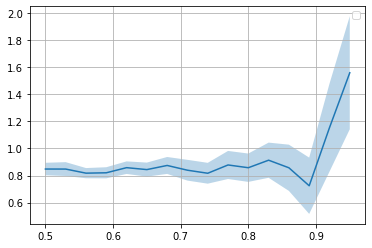

In [395]:
plt.fill_between(me_p.index, y1=me_p['return_rate']-me_p["std"],\
         y2=me_p["return_rate"]+me_p["std"], alpha=0.3)
plt.plot(me_p.index, me_p["return_rate"])
plt.grid()
plt.legend()

No handles with labels found to put in legend.


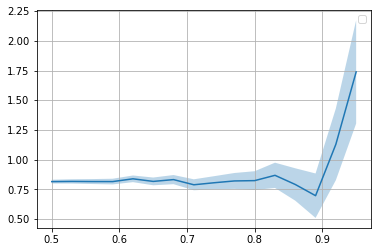

In [417]:
plt.fill_between(me_p2.index, y1=me_p2['return_rate']-me_p2["std"],\
         y2=me_p2["return_rate"]+me_p2["std"], alpha=0.3)
plt.plot(me_p2.index, me_p2["return_rate"])
plt.grid()
plt.legend()

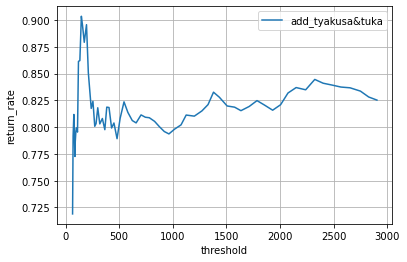

In [59]:
plt.plot(me_p.index, me_p['return_rate'], label='add_tyakusa&tuka')
plt.xlabel('threshold')
plt.ylabel('return_rate')
plt.grid()
plt.legend()

In [26]:
me.feature_importance(X_train)

,features,importance
5,jockey_id,140
10,賞金_5R,129
4,horse_id,101
9,着順_5R,73
7,体重,71
12,first_corner_5R,63
3,course_len,58
18,first_corner_9R,57
55,peds_28,56
1,馬番,55


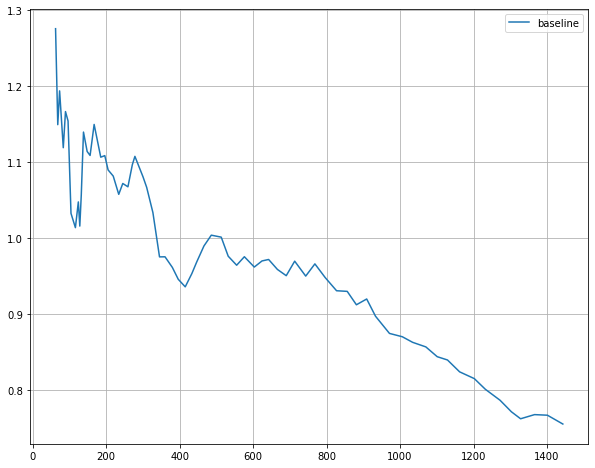

In [193]:
plt.figure(figsize=(10,8))
me_p.rename("baseline").plot(legend=True)

plt.grid()

# 開催日、距離の特徴量の追加

In [430]:
class Horse_Results:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','着順','賞金','着差','通過','開催','距離']]
        self.preprocessing()
        #self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
    
    # path_listはHorse_Results.pickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    # 使い方
    # Horse_Results.read_pickle([pickle名])
    
    @staticmethod
    def scrape(horse_id_list):
        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
        
        
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        #1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        #レース展開データ
        #n=1: 最初のコーナー位置, n=4: 最終コーナー位置
        def corner(x, n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        #開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        #距離
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        
        #インデックス名を与える
        df.index.name = 'horse_id'
    
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner',
                            'first_to_rank', 'first_to_final','final_to_rank']

        
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
          
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list]\
            .mean().add_suffix('_{}R'.format(n_samples))
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])\
                [self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))

    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id',
                             right_index=True, how='left')
        for column in ['course_len','race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], 
                                        left_on=['horse_id', column],
                                        right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat(
            [self.merge(results, date, n_samples) for date in tqdm(date_list)]
        )
        return merged_df
    
   

In [61]:
rr = r.data_p

In [431]:
hr = Horse_Results(horse_results)
r = Results(results_19)
r.preprocessing()
r.merge_horse_results(hr)

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [432]:
p = Peds(n_peds_all)
p.encode()

In [433]:
r.merge_peds(p.peds_e)
r.process_categorical()

In [227]:
#r.data_c.drop(["単勝"],axis=1,inplace=True)
train, test = split_data(r.data_c)
train, valid = split_data(train)

X_train = train.drop(['rank',"date"],axis=1)
y_train = train["rank"]

X_test = test.drop(['rank',"date"],axis=1)
y_test = test["rank"]

X_valid = valid.drop(['rank',"date"],axis=1)
y_valid = valid["rank"]

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    "objective":"binary",
    "random_state": 100
}
lgb_clf_o = lgb_o.train(params, lgb_train,
                valid_sets=(lgb_train, lgb_valid),
                verbose_eval=100,
                early_stopping_rounds=10)

[I 2021-11-27 17:53:07,820] A new study created in memory with name: no-name-809c6edd-9e31-40a2-9daa-b912fc8d632c
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30048
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.424382:  14%|8     | 1/7 [00:00<00:04,  1.33it/s]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.364598	valid_1's binary_logloss: 0.424382
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30048
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.424382:  29%|#7    | 2/7 [00:01<00:03,  1.43it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.359146	valid_1's binary_logloss: 0.425697
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30048
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.424382:  43%|##5   | 3/7 [00:01<00:02,  1.60it/s]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.36955	valid_1's binary_logloss: 0.430535
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30048
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.423564:  57%|###4  | 4/7 [00:02<00:01,  1.58it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.358021	valid_1's binary_logloss: 0.423564
[LightGBM] [Info] Number of positive: 5074, number of negative: 18346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30048
[LightGBM] [Info] Number of data points in the train set: 23420, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216652 -> initscore=-1.285282
[LightGBM] [Info] Start training from score -1.285282
Training until validation scores don't improve for 10 rounds


KeyboardInterrupt: 

In [212]:
lgb_clf_o.params.pop("num_iterations")

1000

In [213]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 5,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9400930505843544,
 'bagging_freq': 2,
 'min_child_samples': 10}

In [214]:
new_params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 5,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9400930505843544,
 'bagging_freq': 2,
 'min_child_samples': 10}

In [434]:
#r.data_c.drop(['単勝'],axis=1,inplace=True)
train, test = split_data(r.data_c)

X_train = train.drop(["rank","date","単勝"], axis=1)
y_train = train['rank']
X_test = test.drop(["rank","date"], axis=1)
y_test = test['rank']

In [435]:
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
me_h2 = ModelEvaluator(lgb_clf, ["Return_tables-Copy1.pickle"])
#add_race_type = gain(me.tansho_return_proper, X_test)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9799999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9799999999999999
[LightGBM] [Warning] bagging_fraction is set=0.8295235542136072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8295235542136072
[LightGBM] [Warning] lambda_l2 is set=1.2839179406304322e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839179406304322e-05
[LightGBM] [Warning] lambda_l1 is set=0.008732558425717211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008732558425717211


In [182]:
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i / n_samples + min_threshold * (1-(i/n_samples))
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets > lower:
            gain[n_bets] = {'return_rate': return_rate, 'n_hits': n_hits}
    return pd.DataFrame(gain).T

In [408]:
me.feature_importance(X_train)

ValueError: All arrays must be of the same length

In [380]:
me_h2.feature_importance(X_train)

,features,importance
4,horse_id,26
5,jockey_id,26
10,賞金_5R,15
7,体重,14
9,着順_5R,13
3,course_len,11
24,賞金_race_type_5R,10
67,着差_allR,10
51,着順_race_type_9R,9
79,着順_race_type_allR,8


In [436]:
bb = gain(me_h2.tansho_return_proper, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/tm/fn98hw1541vg9yshhxdqfgc80000gn/T/ipykernel_99170/392476289.py:96: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = n_hits / (1/ pred_table['単勝']).sum()


In [437]:
bb

,return_rate,n_hits,std,n_bets
0.50,0.809829,697.0,0.017555,4645.0
0.53,0.809337,638.0,0.019870,3991.0
0.56,0.815450,581.0,0.022431,3381.0
0.59,0.815070,507.0,0.025795,2753.0
0.62,0.817810,424.0,0.030202,2138.0
0.65,0.790984,329.0,0.035137,1588.0
0.68,0.801503,256.0,0.041501,1140.0
0.71,0.790920,186.0,0.049051,800.0
0.74,0.804200,134.0,0.058626,522.0
0.77,0.780393,85.0,0.071824,313.0


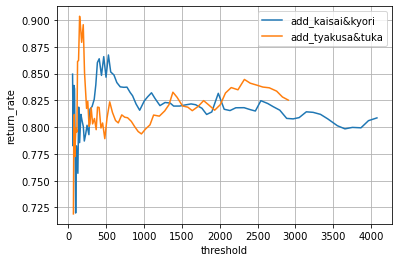

In [254]:
plt.plot(a.index, a['return_rate'], label='add_kaisai&kyori')
plt.plot(me_p.index, me_p['return_rate'], label='add_tyakusa&tuka')
plt.xlabel('threshold')
plt.ylabel('return_rate')
plt.grid()
plt.legend()


In [382]:
a

,return_rate,n_hits,std,n_bets
0.50,0.809829,697.0,0.017555,4645.0
0.53,0.809337,638.0,0.019870,3991.0
0.56,0.815450,581.0,0.022431,3381.0
0.59,0.815070,507.0,0.025795,2753.0
0.62,0.817810,424.0,0.030202,2138.0
0.65,0.790984,329.0,0.035137,1588.0
0.68,0.801503,256.0,0.041501,1140.0
0.71,0.790920,186.0,0.049051,800.0
0.74,0.804200,134.0,0.058626,522.0
0.77,0.780393,85.0,0.071824,313.0


In [426]:
b

,return_rate,n_hits
4077,0.808673,642.0
3965,0.806079,629.0
3866,0.799403,614.0
3753,0.799785,604.0
3654,0.798432,594.0
...,...,...
95,0.719780,25.0
80,0.835793,25.0
72,0.839000,23.0
62,0.782453,20.0


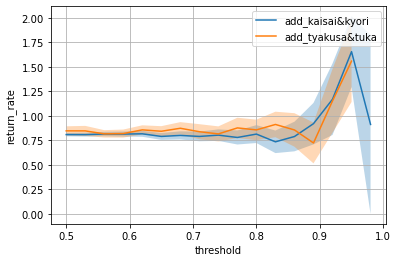

In [428]:
plt.fill_between(a.index, y1=a["return_rate"]-a["std"],\
                y2=a["return_rate"]+a["std"], alpha=0.3)
plt.plot(a.index, a["return_rate"],label='add_kaisai&kyori')
plt.fill_between(me_p.index, y1=me_p['return_rate']-me_p["std"],\
         y2=me_p["return_rate"]+me_p["std"], alpha=0.3)
plt.plot(me_p.index, me_p["return_rate"],label='add_tyakusa&tuka')
plt.grid()
plt.xlabel("threshold")
plt.ylabel('return_rate')
plt.legend()
#単勝の回収率の比較

In [429]:
me_p

,return_rate,n_hits,std,n_bets
0.50,0.847913,745.0,0.046200,5222.0
0.53,0.847673,684.0,0.051208,4470.0
0.56,0.817423,618.0,0.037721,3788.0
0.59,0.820186,546.0,0.041075,3126.0
0.62,0.858062,478.0,0.046480,2487.0
0.65,0.843770,384.0,0.051925,1894.0
0.68,0.874420,307.0,0.062610,1380.0
0.71,0.839232,210.0,0.076813,938.0
0.74,0.816720,153.0,0.077064,622.0
0.77,0.878030,108.0,0.103752,396.0


In [440]:
bb

,return_rate,n_hits,std,n_bets
0.50,0.809829,697.0,0.017555,4645.0
0.53,0.809337,638.0,0.019870,3991.0
0.56,0.815450,581.0,0.022431,3381.0
0.59,0.815070,507.0,0.025795,2753.0
0.62,0.817810,424.0,0.030202,2138.0
0.65,0.790984,329.0,0.035137,1588.0
0.68,0.801503,256.0,0.041501,1140.0
0.71,0.790920,186.0,0.049051,800.0
0.74,0.804200,134.0,0.058626,522.0
0.77,0.780393,85.0,0.071824,313.0


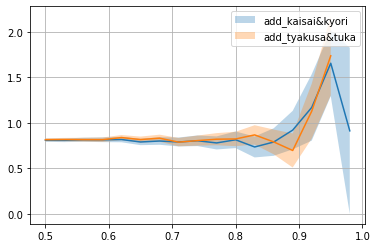

In [439]:
plt.plot(bb.index, bb["return_rate"])
plt.plot(me_p2.index, me_p2["return_rate"])

plt.fill_between(bb.index, y1=bb["return_rate"]-bb["std"],\
                y2=bb["return_rate"]+bb["std"], alpha=0.3, label="add_kaisai&kyori")
plt.fill_between(me_p2.index, y1=me_p2["return_rate"]+me_p2["std"],\
                y2=me_p2["return_rate"]-me_p2["std"], alpha=0.3, label="add_tyakusa&tuka")
plt.grid()
plt.legend()

In [255]:
a = gain(me_h.tansho_return, X_test)
b = gain(me_h.tansho_return_proper, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

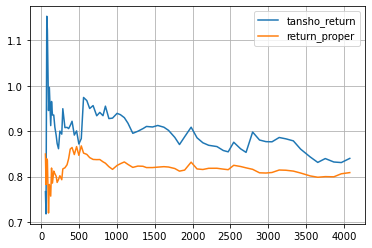

In [261]:
plt.plot(a.index, a['return_rate'], label='tansho_return')
plt.plot(b.index, b['return_rate'], label='return_proper')
plt.legend()
plt.grid()

#　標準偏差の追加

In [262]:
#第一引数にあたるxにはX_testのようなテストデータを入れる
# return_tables_path = pickle_path
class ModelEvaluator:
    def __init__(self, model, return_tables_list, std=True):
        self.model = model
        self.rt = Return.read_pickle(return_tables_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
    
    #閾値(threshold)を設定する　デフォルト0.6
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    #1になる確率の予測
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X.drop(["単勝"],axis=1))[:,1], index=X.index)
        if self.std:
            standerd_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standerd_scaler)
        proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba 
    
    #auc曲線のスコアを求める
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    #各成分の特徴量の強さの表示 デフォルト20
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features":X.columns, 
                                  "importance":self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    #閾値を通して1と判定されたものだけをpred_tableとして出力する
    def pred_table(self, X, threshold=0.6, bet_only = True):
        pred_table = X.copy()[['馬番',"単勝"]]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番',"単勝"]]
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        n_hits = len(df[df["win"]==df["馬番"]])
        money += df[df['win']==df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        
        std = ((df['win'] == df['馬番'])*\
               df['return']).groupby(level=0).sum().std() *\
                np.sqrt(n_races)/(n_bets*100)
        
        
        return n_bets, return_rate, n_hits, std
        #self.df = df
        #self.tansho_df = self.tansho.copy()
    
    def tansho_return_proper(self, X, threshold=0.5):
        #モデルによって儲かると判断された馬
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        #払い戻しの際にpred_tableを混ぜる
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        #self.s_df = df 
        
        bet_money = (1 / pred_table["単勝"]).sum()
    
        std = ((df["win"] == df["馬番"]).astype(int).groupby(level=0).sum().std()\
               * np.sqrt(n_races) / bet_money)
        
        #単勝適正回収率の計算
        n_hits = len(df.query("win == 馬番"))
        return_rate = n_hits / (1/ pred_table['単勝']).sum()
        
        return n_bets, return_rate, n_hits, std
    
    def umaren_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds, 2))
            hit[race_id] = set(
                self.umaren.loc[race_id][[0, 1]]
            ).issubset(set(preds))
        return_rate = self.umaren.index.map(hit).values * self.umaren['return'].sum() / \
            (n_bets * 100)
        return n_bets, return_rate
      

In [282]:
#第一引数にあたるxにはX_testのようなテストデータを入れる
# return_tables_path = pickle_path
class ModelEvaluator:
    def __init__(self, model, return_tables_list, std=True):
        self.model = model
        self.rt = Return.read_pickle(return_tables_list)
        #self.rt = return_tables_list
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
    
    #閾値(threshold)を設定する　デフォルト0.6
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    #1になる確率の予測
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X.drop(["単勝"],axis=1))[:,1], index=X.index)
        if self.std:
            standerd_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standerd_scaler)
        proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba 
    
    #auc曲線のスコアを求める
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    #各成分の特徴量の強さの表示 デフォルト20
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features":X.columns, 
                                  "importance":self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    #閾値を通して1と判定されたものだけをpred_tableとして出力する
    def pred_table(self, X, threshold=0.6, bet_only = True):
        pred_table = X.copy()[['馬番',"単勝"]]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番',"単勝"]]
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        n_hits = len(df[df["win"]==df["馬番"]])
        money += df[df['win']==df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        
        std = ((df['win'] == df['馬番'])*\
               df['return']).groupby(level=0).sum().std() *\
                np.sqrt(n_races)/(n_bets*100)
        
        
        return n_bets, return_rate, n_hits, std
        #self.df = df
        #self.tansho_df = self.tansho.copy()
    
    def tansho_return_proper(self, X, threshold=0.5):
        #モデルによって儲かると判断された馬
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        #払い戻しの際にpred_tableを混ぜる
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        #self.s_df = df 
        
        bet_money = (1 / pred_table["単勝"]).sum()
    
        std = ((df["win"] == df["馬番"]).astype(int).groupby(level=0).sum().std()\
               * np.sqrt(n_races) / bet_money)
        
        #単勝適正回収率の計算
        n_hits = len(df.query("win == 馬番"))
        return_rate = n_hits / (1/ pred_table['単勝']).sum()
        
        return n_bets, return_rate, n_hits, std
    
    def umaren_return(self, X, threshold=0.6):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds, 2))
            hit[race_id] = set(
                self.umaren.loc[race_id][[0, 1]]
            ).issubset(set(preds))
        return_rate = self.umaren.index.map(hit).values * self.umaren['return'].sum() / \
            (n_bets * 100)
        return n_bets, return_rate
      

In [313]:
me = ModelEvaluator(lgb_clf, ["Return_tables_all.pickle"])

In [315]:
aa = gain(me.tansho_return_proper, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/tm/fn98hw1541vg9yshhxdqfgc80000gn/T/ipykernel_99170/392476289.py:96: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = n_hits / (1/ pred_table['単勝']).sum()


In [ ]:
plt.fill_between(df.index, y1=df['return_rate']-df['std'],
        y2=df['return_rate']+df['std'],alpha=0.3)
 

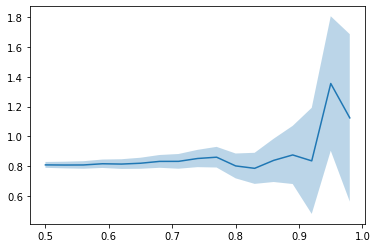

In [319]:
plt.fill_between(aa.index, y1=aa['return_rate']-aa['std'],y2=aa['return_rate']+aa["std"], alpha=0.3)
plt.plot(aa.index, aa["return_rate"])

In [320]:
aa

,return_rate,n_hits,std,n_bets
0.50,0.808673,642.0,0.019692,4077.0
0.53,0.807737,576.0,0.022437,3427.0
0.56,0.808198,515.0,0.025268,2884.0
0.59,0.816329,460.0,0.028317,2405.0
0.62,0.814211,387.0,0.032532,1894.0
0.65,0.819739,323.0,0.037064,1470.0
0.68,0.832127,259.0,0.043005,1097.0
0.71,0.832422,202.0,0.049407,815.0
0.74,0.851612,152.0,0.058119,558.0
0.77,0.860371,109.0,0.069385,382.0


In [302]:
me.feature_importance(X_train)

,features,importance
5,jockey_id,105
4,horse_id,82
7,体重,69
10,賞金_5R,54
24,賞金_race_type_5R,52
23,着順_race_type_5R,43
94,peds_1,42
9,着順_5R,41
152,peds_59,39
67,着差_allR,38
